In [1]:
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
from tensorflow.python.client import device_lib

print('Tensorflow version ' + tf.__version__)
device_lib.list_local_devices()

Tensorflow version 2.10.0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12816291805991526806
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6235881472
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2751412066406409104
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:08:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [2]:
# pixel labels in the video frames
class_names = ['sky', 'building','column/pole', 'road', 'side walk', 'vegetation', 'traffic light', 'fence', 'vehicle', 'pedestrian', 'bicyclist', 'void']

In [3]:
train_image_path = '../Dataset/images_prepped_train/'
train_label_path = '../Dataset/annotations_prepped_train/'
test_image_path = '../Dataset/images_prepped_test/'
test_label_path = '../Dataset/annotations_prepped_test/'
 
BATCH_SIZE = 16

In [4]:
def map_filename_to_image_and_mask(t_filename, a_filename, height=224, width=224):
 
    # Convert image and mask files to tensors
    img_raw = tf.io.read_file(t_filename)
    anno_raw = tf.io.read_file(a_filename)
    image = tf.image.decode_jpeg(img_raw)
    annotation = tf.image.decode_jpeg(anno_raw)
 
    # Resize image and segmentation mask
    image = tf.image.resize(image, (height, width,))
    annotation = tf.image.resize(annotation, (height, width,))
    image = tf.reshape(image, (height, width, 3,))
    annotation = tf.cast(annotation, dtype=tf.int32)
    annotation = tf.reshape(annotation, (height, width, 1,))
    stack_list = []
 
    # Reshape segmentation masks
    for c in range(len(class_names)):
        mask = tf.equal(annotation[:,:,0], tf.constant(c))
        stack_list.append(tf.cast(mask, dtype=tf.int32))
    
    annotation = tf.stack(stack_list, axis=2)
 
    # Normalize pixels in the input image
    image = image / 127.5
    image -= 1
 
    return image, annotation
 
def get_dataset_slice_paths(image_dir, label_map_dir):
 
    image_file_list = os.listdir(image_dir)
    label_map_file_list = os.listdir(label_map_dir)
    image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]
    label_map_paths = [os.path.join(label_map_dir, fname) for fname in label_map_file_list]
 
    return image_paths, label_map_paths
 
def get_training_dataset(image_paths, label_map_paths):

    training_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
    training_dataset = training_dataset.map(map_filename_to_image_and_mask)
    training_dataset = training_dataset.shuffle(100, reshuffle_each_iteration=True)
    training_dataset = training_dataset.batch(BATCH_SIZE)
    training_dataset = training_dataset.repeat()
    training_dataset = training_dataset.prefetch(-1)
 
    return training_dataset
 
def get_validation_dataset(image_paths, label_map_paths):
   
    validation_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
    validation_dataset = validation_dataset.map(map_filename_to_image_and_mask)
    validation_dataset = validation_dataset.batch(BATCH_SIZE)
    validation_dataset = validation_dataset.repeat()
 
    return validation_dataset

In [5]:
# get the paths to the images
training_image_paths, training_label_map_paths = get_dataset_slice_paths(train_image_path, train_label_path)
validation_image_paths, validation_label_map_paths = get_dataset_slice_paths(test_image_path, test_label_path)
# generate the train and valid sets
training_dataset = get_training_dataset(training_image_paths, training_label_map_paths)
validation_dataset = get_validation_dataset(validation_image_paths, validation_label_map_paths)

In [6]:
# generate a list that contains one color for each class
colors = sns.color_palette(None, len(class_names))
 
for class_name, color in zip(class_names, colors):
    print(f'{class_name} -- {color}')

sky -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
building -- (1.0, 0.4980392156862745, 0.054901960784313725)
column/pole -- (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
road -- (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
side walk -- (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
vegetation -- (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
traffic light -- (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
fence -- (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
vehicle -- (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)
pedestrian -- (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)
bicyclist -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
void -- (1.0, 0.4980392156862745, 0.054901960784313725)


In [7]:
# Visualization Utilities
 
def fuse_with_pil(images):
 
    widths = (image.shape[1] for image in images)
    heights = (image.shape[0] for image in images)
    total_width = sum(widths)
    max_height = max(heights)
 
    new_im = PIL.Image.new('RGB', (total_width, max_height))
 
    x_offset = 0
    for im in images:
        pil_image = PIL.Image.fromarray(np.uint8(im))
        new_im.paste(pil_image, (x_offset,0))
        x_offset += im.shape[1]
  
    return new_im
 
 
def give_color_to_annotation(annotation):
    seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')
  
    for c in range(12):
        segc = (annotation == c)
        seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
        seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
        seg_img[:,:,2] += segc*( colors[c][2] * 255.0)
  
    return seg_img
 
 
def show_predictions(image, labelmaps, titles, iou_list, dice_score_list):
 
    true_img = give_color_to_annotation(labelmaps[1])
    pred_img = give_color_to_annotation(labelmaps[0])
 
    image = image + 1
    image = image * 127.5
    images = np.uint8([image, pred_img, true_img])
 
    metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
    metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place
  
    display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
    display_string = "\n\n".join(display_string_list) 
 
    plt.figure(figsize=(15, 4))
 
    for idx, im in enumerate(images):
        plt.subplot(1, 3, idx+1)
        if idx == 1:
            plt.xlabel(display_string)
        plt.xticks([])
        plt.yticks([])
        plt.title(titles[idx], fontsize=12)
        plt.imshow(im)
 
 
def show_annotation_and_image(image, annotation):
    new_ann = np.argmax(annotation, axis=2)
    seg_img = give_color_to_annotation(new_ann)
  
    image = image + 1
    image = image * 127.5
    image = np.uint8(image)
    images = [image, seg_img]
  
    images = [image, seg_img]
    fused_img = fuse_with_pil(images)
    plt.imshow(fused_img)
 
 
def list_show_annotation(dataset):
 
    ds = dataset.unbatch()
    ds = ds.shuffle(buffer_size=100)
 
    plt.figure(figsize=(25, 15))
    plt.title("Images And Annotations")
    plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)
 
    # we set the number of image-annotation pairs to 9
    # feel free to make this a function parameter if you want
    for idx, (image, annotation) in enumerate(ds.take(9)):
        plt.subplot(3, 3, idx + 1)
        plt.yticks([])
        plt.xticks([])
        show_annotation_and_image(image.numpy(), annotation.numpy())

C:\Users\wndyd\AppData\Local\Temp\ipykernel_3432\1296731190.py:86: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, idx + 1)


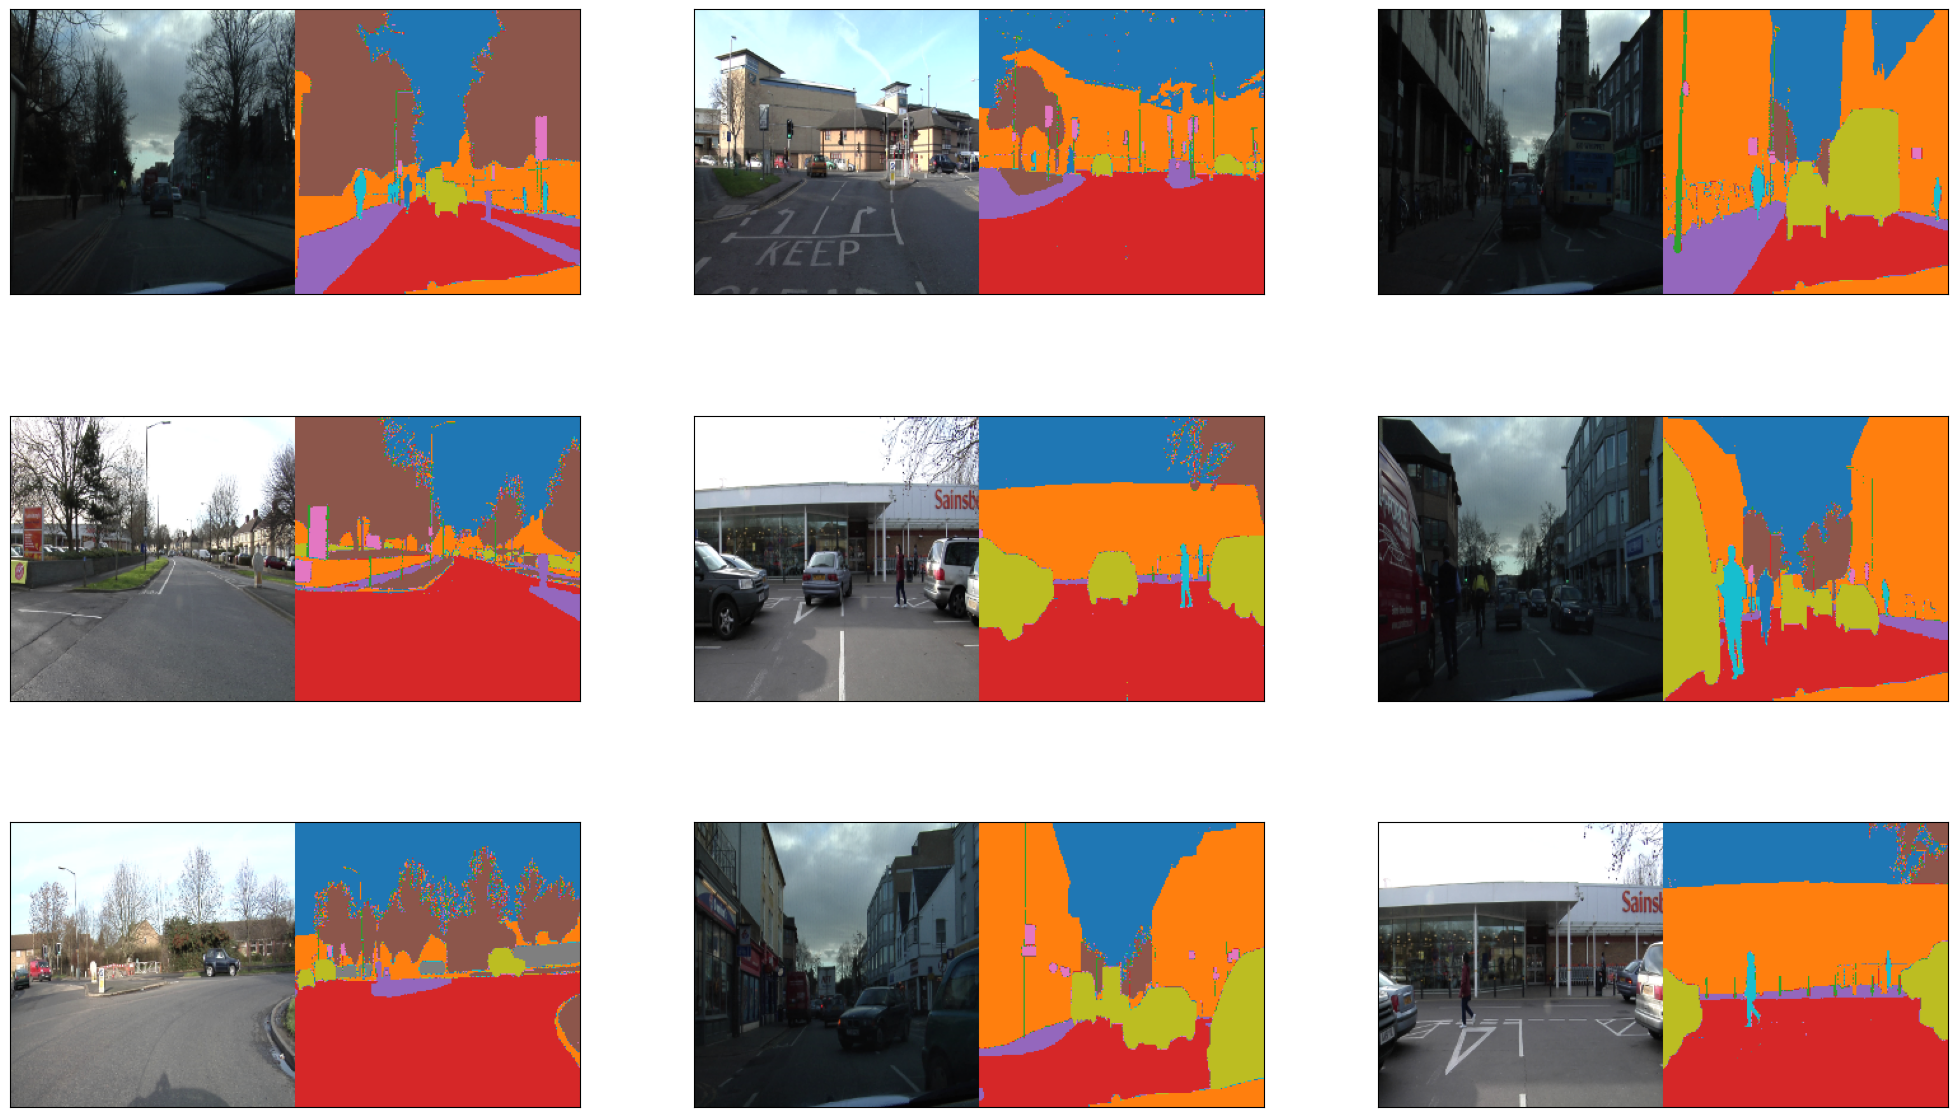

In [8]:
list_show_annotation(training_dataset)

In [9]:
def block(x, n_convs, filters, kernel_size, activation, pool_size, pool_stride, block_name):
    for i in range(n_convs):
        x = tf.keras.layers.Conv2D(filters=filters,
                                   kernel_size=kernel_size,
                                   activation=activation,
                                   padding='same',
                                   name=f'{block_name}_conv{i+1}')(x)
    
    x = tf.keras.layers.MaxPooling2D(pool_size=pool_size,
                                     strides=pool_stride,
                                     name=f'{block_name}_pool{i+1}')(x)
    
    return x

In [10]:
vgg_weights_path = "../vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [11]:
def VGG_16(image_input):
 
    # create 5 blocks with increasing filters at each stage
    x = block(image_input, n_convs=2, filters=64, kernel_size=(3,3), activation='relu',
              pool_size=(2,2), pool_stride=(2,2),
              block_name='block1')
    p1 = x # (112, 112, 64)
 
    x = block(x, n_convs=2, filters=128, kernel_size=(3,3), activation='relu',
              pool_size=(2,2), pool_stride=(2,2),
              block_name='block2')
    p2 = x # (56, 56, 128)
 
    x = block(x, n_convs=3, filters=256, kernel_size=(3,3), activation='relu',
              pool_size=(2,2), pool_stride=(2,2),
              block_name='block3')
    p3 = x # (28, 28, 256)
 
    x = block(x, n_convs=3, filters=512, kernel_size=(3,3), activation='relu',
              pool_size=(2,2), pool_stride=(2,2),
              block_name='block4')
    p4 = x # (14, 14, 512)
 
    x = block(x, n_convs=3, filters=512, kernel_size=(3,3), activation='relu',
              pool_size=(2,2), pool_stride=(2,2),
              block_name='block5')
    p5 = x # (7, 7, 512)
 
    # create the vgg model
    vgg = tf.keras.Model(image_input, p5)
 
    # load the pretrained weights downloaded
    vgg.load_weights(vgg_weights_path)
 
    # number of filters for the output convolutional layers
    n = 4096
 
    # our input images are 224x224 pixels so they will be downsampled to 7x7 after the pooling layers above.
    # we can extract more features by chaining two more convolution layers.
    c6 = tf.keras.layers.Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6")(p5)
    c7 = tf.keras.layers.Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7")(c6)
 
    # return the outputs at each stage. you will only need two of these in this particular exercise 
    # but we included it all in case you want to experiment with other types of decoders.
    return (p1, p2, p3, p4, c7)

In [12]:
def decoder(convs, n_classes):
     
    # unpack the output of the encoder
    f1, f2, f3, f4, f5 = convs 
    """f1 = (112, 112, 64)
       f2 = (56, 56, 128)
       f3 = (28, 28, 256)
       f4 = (14, 14, 512)
       f5 = (7, 7, 512) """
 
    # FCN-32 output
    fcn32_o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(32,32), strides=(32, 32), use_bias=False)(f5)
    fcn32_o = tf.keras.layers.Activation('softmax')(fcn32_o)
 
    # upsample the output of the encoder then crop extra pixels that were introduced
    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4,4), strides=(2,2), use_bias=False)(f5) # (16, 16, n)
    o = tf.keras.layers.Cropping2D(cropping=(1,1))(o) # (14, 14, n)
 
    # load the pool4 prediction and do a 1x1 convolution to reshape it to the same shape of 'o' above
    o2 = f4 # (14, 14, 512)
    o2 = tf.keras.layers.Conv2D(n_classes, (1,1), activation='relu', padding='same')(o2) # (14, 14, n)
 
    # add the result of the upsampling and pool4 prediction
    o = tf.keras.layers.Add()([o, o2]) # (14, 14, n)
 
    # FCN-16 output
    fcn16_o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(16,16), strides=(16,16), use_bias=False)(o)
    fcn16_o = tf.keras.layers.Activation('softmax')(fcn16_o)
 
    # upsample the resulting tensor of the operation you just did
    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4,4), strides=(2,2), use_bias=False)(o) # (30, 30, n)
    o = tf.keras.layers.Cropping2D(cropping=(1,1))(o) # (28, 28, n)
 
    # load the pool3 prediction and do a 1x1 convolution to reshape it to shame shape of 'o' above
    o2 = f3 # (28, 28, 256)
    o2 = tf.keras.layers.Conv2D(n_classes, (1,1), activation='relu', padding='same')(o2) # (28, 28, n)
 
    # add the result of the upsampling and pool3 prediction
    o = tf.keras.layers.Add()([o, o2]) # (28, 28, n)
 
    # upsample up to the size of the original image
    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(8,8), strides=(8,8), use_bias=False)(o) # (224, 224, n)
 
    # append a softmax to get the class probabilities
    fcn8_o = tf.keras.layers.Activation('softmax')(o)
 
    return fcn32_o, fcn16_o, fcn8_o

In [13]:
def segmentation_model():
     
    inputs = tf.keras.layers.Input(shape=(224,224,3,))
    convs = VGG_16(inputs)
    fcn32, fcn16, fcn8 = decoder(convs, 12)
    model_fcn32 = tf.keras.Model(inputs, fcn32)
    model_fcn16 = tf.keras.Model(inputs, fcn16)
    model_fcn8 = tf.keras.Model(inputs, fcn8)
 
    return model_fcn32, model_fcn16, model_fcn8
    
model_fcn32, model_fcn16, model_fcn8 = segmentation_model()

In [14]:
model_fcn32.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool2 (MaxPooling2D)  (None, 112, 112, 64)     0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool2 (MaxPooling2D)  (None, 56, 56, 128)      0   

In [15]:
model_fcn16.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [16]:
model_fcn8.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [17]:
sgd = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, nesterov=True)
model_fcn32.compile(loss='categorical_crossentropy',
                    optimizer=sgd,
                    metrics=['acc'])
model_fcn16.compile(loss='categorical_crossentropy',
                    optimizer=sgd,
                    metrics=['acc'])
model_fcn8.compile(loss='categorical_crossentropy',
                   optimizer=sgd,
                   metrics=['acc'])

In [18]:
# number of training images
train_count = len(training_image_paths)
 
# number of validation images
valid_count = len(validation_image_paths)
 
EPOCHS = 170
 
steps_per_epoch = train_count//BATCH_SIZE
validation_steps = valid_count//BATCH_SIZE

print(train_count, valid_count)

367 101


In [19]:
with tf.device('/device:GPU:0'):
    history_fcn32 = model_fcn32.fit(training_dataset,
                                    steps_per_epoch=steps_per_epoch,
                                    validation_data=validation_dataset,
                                    validation_steps=validation_steps,
                                    epochs=100)

Epoch 1/100


22/22 [==============================] - 17s 524ms/step - loss: 2.4829 - acc: 0.1717 - val_loss: 2.4798 - val_acc: 0.2920
Epoch 2/100
22/22 [==============================] - 15s 521ms/step - loss: 2.4683 - acc: 0.3470 - val_loss: 2.4420 - val_acc: 0.3201
Epoch 3/100
22/22 [==============================] - 11s 521ms/step - loss: 2.0771 - acc: 0.3730 - val_loss: 1.5431 - val_acc: 0.5117
Epoch 4/100
22/22 [==============================] - 11s 511ms/step - loss: 1.2160 - acc: 0.5955 - val_loss: 1.4397 - val_acc: 0.5775
Epoch 5/100
22/22 [==============================] - 11s 516ms/step - loss: 1.1096 - acc: 0.6353 - val_loss: 1.2879 - val_acc: 0.5925
Epoch 6/100
22/22 [==============================] - 11s 510ms/step - loss: 1.0703 - acc: 0.6555 - val_loss: 1.1804 - val_acc: 0.6064
Epoch 7/100
22/22 [==============================] - 11s 520ms/step - loss: 0.9903 - acc: 0.6807 - val_loss: 1.1433 - val_acc: 0.6039
Epoch 8/100
22/22 [==============================] - 11s 516ms/step - loss

In [20]:
with tf.device('/device:GPU:0'):
    history_fcn16 = model_fcn16.fit(training_dataset,
                                    steps_per_epoch=steps_per_epoch,
                                    validation_data=validation_dataset,
                                    validation_steps=validation_steps,
                                    epochs=EPOCHS)

Epoch 1/170
22/22 [==============================] - 10s 418ms/step - loss: 2.5558 - acc: 0.0853 - val_loss: 2.4846 - val_acc: 0.0867
Epoch 2/170
22/22 [==============================] - 8s 384ms/step - loss: 2.4782 - acc: 0.1061 - val_loss: 2.4700 - val_acc: 0.1272
Epoch 3/170
22/22 [==============================] - 8s 378ms/step - loss: 2.3723 - acc: 0.1817 - val_loss: 2.2242 - val_acc: 0.2523
Epoch 4/170
22/22 [==============================] - 8s 378ms/step - loss: 1.9132 - acc: 0.3214 - val_loss: 1.8442 - val_acc: 0.3270
Epoch 5/170
22/22 [==============================] - 8s 379ms/step - loss: 1.4789 - acc: 0.4983 - val_loss: 1.5148 - val_acc: 0.5399
Epoch 6/170
22/22 [==============================] - 8s 379ms/step - loss: 1.1262 - acc: 0.6731 - val_loss: 1.2584 - val_acc: 0.6051
Epoch 7/170
22/22 [==============================] - 8s 381ms/step - loss: 0.9915 - acc: 0.6899 - val_loss: 1.1025 - val_acc: 0.6057
Epoch 8/170
22/22 [==============================] - 8s 385ms/step -

In [21]:
with tf.device('/device:GPU:0'):
    history_fcn8 = model_fcn8.fit(training_dataset,
                                steps_per_epoch=steps_per_epoch,
                                validation_data=validation_dataset,
                                validation_steps=validation_steps,
                                epochs=EPOCHS)

Epoch 1/170
22/22 [==============================] - 10s 393ms/step - loss: 2.8140 - acc: 0.0832 - val_loss: 2.4854 - val_acc: 0.0737
Epoch 2/170
22/22 [==============================] - 8s 382ms/step - loss: 2.4756 - acc: 0.1147 - val_loss: 2.4299 - val_acc: 0.1632
Epoch 3/170
22/22 [==============================] - 8s 387ms/step - loss: 1.9782 - acc: 0.3573 - val_loss: 1.7211 - val_acc: 0.4258
Epoch 4/170
22/22 [==============================] - 9s 390ms/step - loss: 1.4525 - acc: 0.5553 - val_loss: 1.3516 - val_acc: 0.5625
Epoch 5/170
22/22 [==============================] - 8s 384ms/step - loss: 1.2576 - acc: 0.6153 - val_loss: 1.2166 - val_acc: 0.5768
Epoch 6/170
22/22 [==============================] - 8s 386ms/step - loss: 1.2305 - acc: 0.6241 - val_loss: 1.2628 - val_acc: 0.5690
Epoch 7/170
22/22 [==============================] - 8s 384ms/step - loss: 1.1834 - acc: 0.6242 - val_loss: 1.2312 - val_acc: 0.5682
Epoch 8/170
22/22 [==============================] - 8s 385ms/step -

In [22]:
def get_images_and_segments_test_arrays():
    y_true_segments = []
    y_true_images = []
    test_count = 64
    
    ds = validation_dataset.unbatch()
    ds = ds.batch(101)
    
    for image, annotation in ds.take(1):
        y_true_images = image
        y_true_segments = annotation
    
    y_true_segments = y_true_segments[:test_count,:,:,:]
    y_true_segments = np.argmax(y_true_segments, axis=3)
    
    return y_true_images, y_true_segments

y_true_images, y_true_segments = get_images_and_segments_test_arrays()

In [23]:
results_fcn32 = model_fcn32.predict(validation_dataset, steps=validation_steps)
results_fcn16 = model_fcn16.predict(validation_dataset, steps=validation_steps)
results_fcn8 = model_fcn8.predict(validation_dataset, steps=validation_steps)

results_fcn32 = np.argmax(results_fcn32, axis=3)
results_fcn16 = np.argmax(results_fcn16, axis=3)
results_fcn8 = np.argmax(results_fcn8, axis=3)

6/6 [==============================] - 1s 94ms/step


In [24]:
def compute_metrics(y_true, y_pred) :
    class_wise_iou = []
    class_wise_dice_score = []
    
    smoothening_factor = 0.00001
    
    for i in range(12):
        intersection = np.sum((y_pred == i) * (y_true == i))
        y_true_area = np.sum((y_true == i))
        y_pred_area = np.sum((y_pred == i))
        combined_area = y_true_area + y_pred_area
 
        iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
        class_wise_iou.append(iou)
 
        dice_score = 2*((intersection + smoothening_factor) / (combined_area + smoothening_factor))
        class_wise_dice_score.append(dice_score)
 
    return class_wise_iou, class_wise_dice_score
    

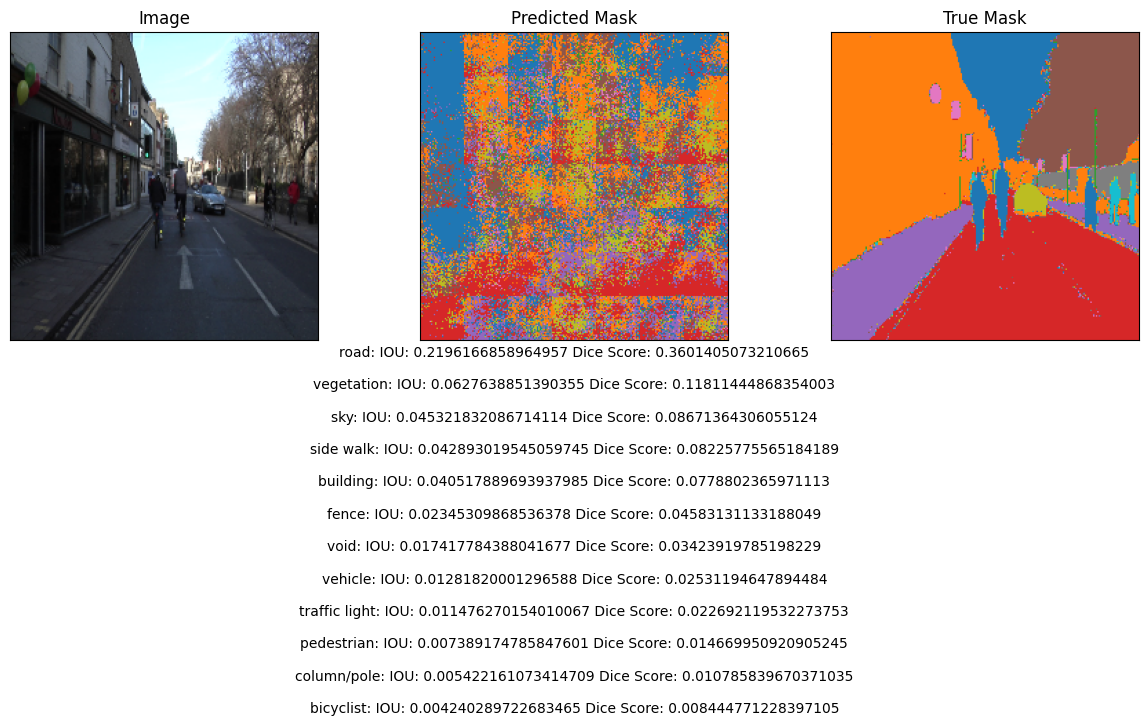

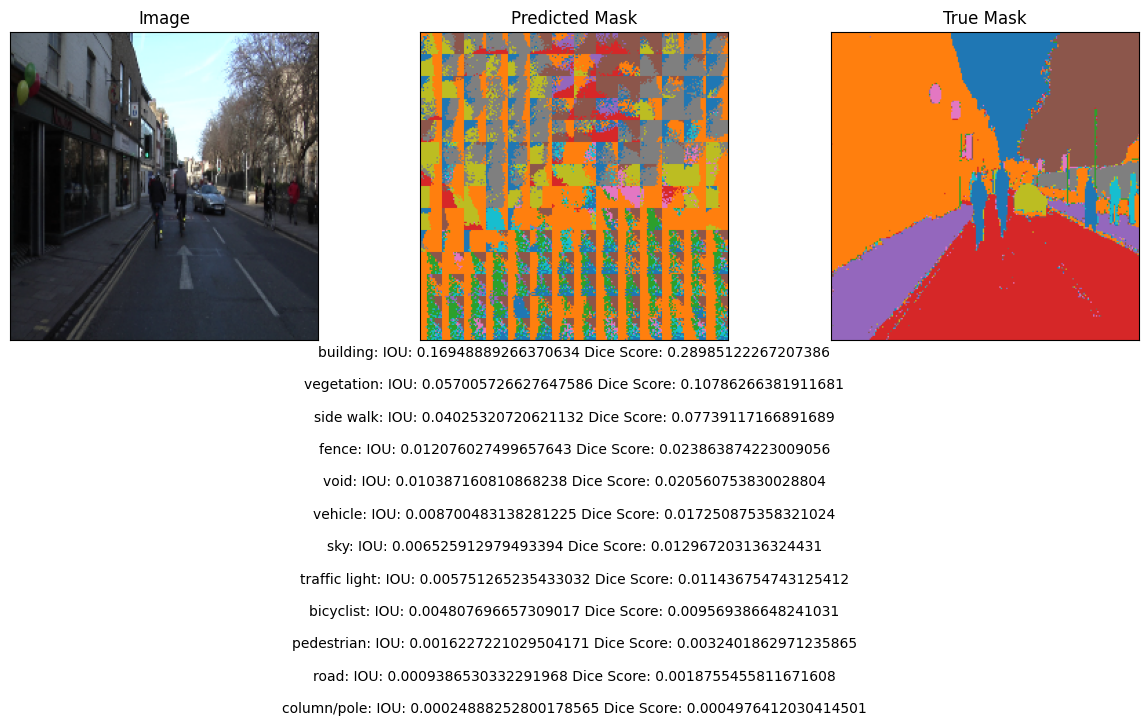

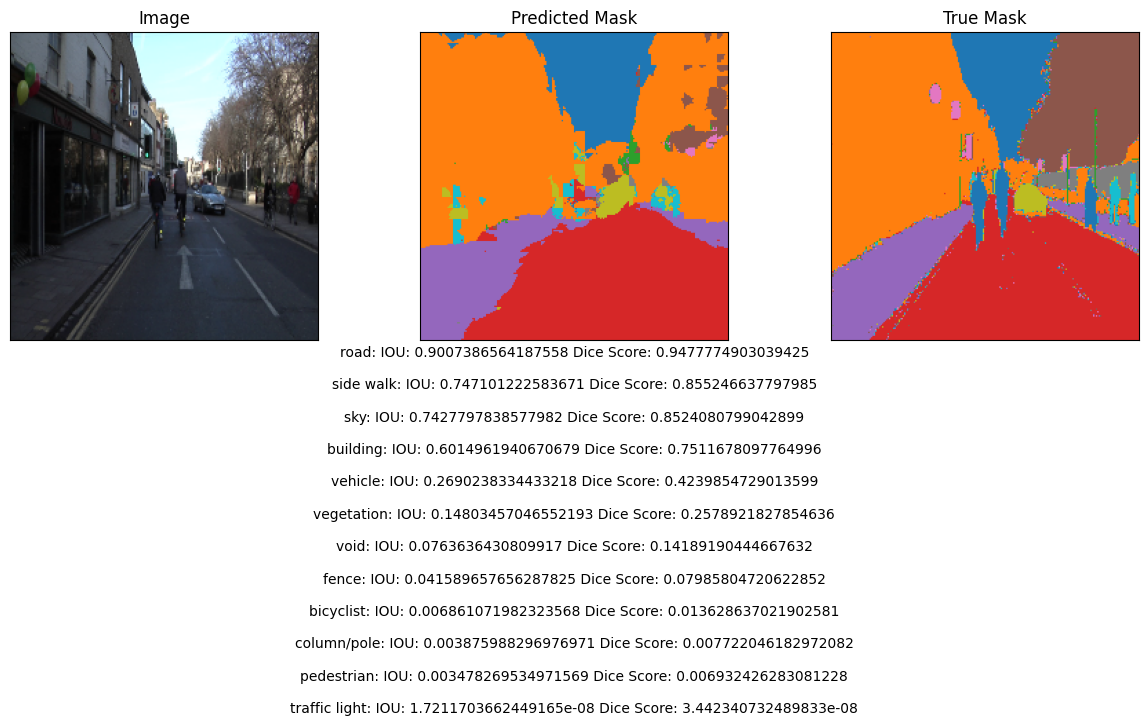

In [25]:
integer_slider = 20

iou_fcn32, dice_score_fcn32 = compute_metrics(y_true_segments[integer_slider], results_fcn32[integer_slider])
iou_fcn16, dice_score_fcn16 = compute_metrics(y_true_segments[integer_slider], results_fcn16[integer_slider])
iou_fcn8, dice_score_fcn8 = compute_metrics(y_true_segments[integer_slider], results_fcn8[integer_slider])

show_predictions(y_true_images[integer_slider], [results_fcn32[integer_slider], y_true_segments[integer_slider]], ["Image", "Predicted Mask", "True Mask"], iou_fcn32, dice_score_fcn32)
show_predictions(y_true_images[integer_slider], [results_fcn16[integer_slider], y_true_segments[integer_slider]], ["Image", "Predicted Mask", "True Mask"], iou_fcn16, dice_score_fcn16)
show_predictions(y_true_images[integer_slider], [results_fcn8[integer_slider], y_true_segments[integer_slider]], ["Image", "Predicted Mask", "True Mask"], iou_fcn8, dice_score_fcn8)